# SSD --- 使用Gluon

这一章下面我们将实现[上一章](./object-detection.md)介绍的SSD来检测野生皮卡丘。

![](../img/pikachu.png)


## 数据集

为此我们合成了一个人工数据集。我们首先使用一个开源的皮卡丘3D模型，用其生成1000张不同角度和大小的照片。然后将其随机的放在背景图片里。我们将图片打包成`rec`文件，这是一个MXNet常用的二进制数据格式。我们可以使用MXNet下的[tools/im2rec.py](https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py)来将图片打包。（TODO(@mli) 加一个教程关于如何使用im2rec）。

### 下载数据

打包好的数据可以直接在网上下载：

In [1]:
from mxnet import gluon

root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
            'gluon/dataset/pikachu/')
data_dir = '../data/pikachu/'
dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
          'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
          'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
for k, v in dataset.items():
    gluon.utils.download(root_url+k, data_dir+k, sha1_hash=v)

### 读取数据集

我们使用`image.ImageDetIter`来读取数据。这是针对物体检测的迭代器，(Det表示Detection)。它跟`image.ImageIter`使用很类似。主要不同是它返回的标号不是单个图片标号，而是每个图片里所有物体的标号，以及其对用的边框。

In [2]:
from mxnet import image
from mxnet import nd

data_shape = 256
batch_size = 32
rgb_mean = nd.array([123, 117, 104])

def get_iterators(data_shape, batch_size):
    class_names = ['pikachu']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec=data_dir+'train.rec',
        path_imgidx=data_dir+'train.idx',
        shuffle=True,
        mean=True,
        rand_crop=1,
        min_object_covered=0.95,
        max_attempts=200)
    val_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec=data_dir+'val.rec',
        shuffle=False,
        mean=True)
    return train_iter, val_iter, class_names, num_class

train_data, test_data, class_names, num_class = get_iterators(
    data_shape, batch_size)

我们读取一个批量。可以看到标号的形状是`batch_size x num_object_per_image x 5`。这里数据里每个图片里面只有一个标号。每个标号由长为5的数组表示，第一个元素是其对用物体的标号，其中`-1`表示非法物体，仅做填充使用。后面4个元素表示边框。

In [3]:
batch = train_data.next()
print(batch)

DataBatch: data shapes: [(32, 3, 256, 256)] label shapes: [(32, 1, 5)]


### 图示数据

我们画出几张图片和其对应的标号。可以看到比卡丘的角度大小位置在每张图图片都不一样。不过也注意到这个数据集是直接将二次元动漫皮卡丘跟三次元背景相结合。可能通过简单判断区域的色彩直方图就可以有效的区别是不是有我们要的物体。我们用这个简单数据集来演示SSD是如何工作的。实际中遇到的数据集通常会复杂很多。

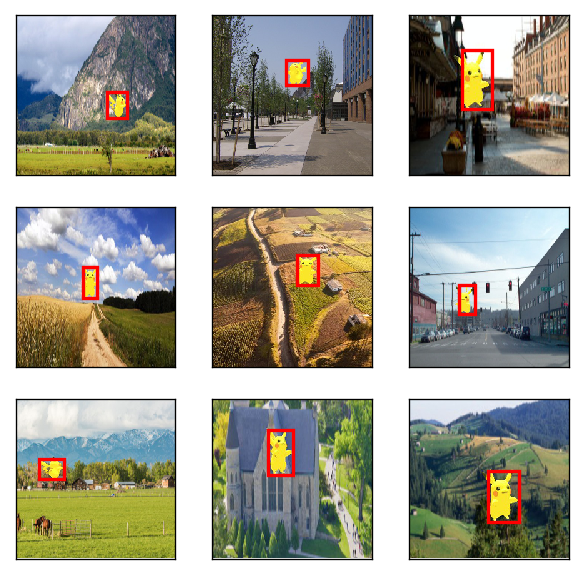

In [4]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), box[2]-box[0], box[3]-box[1],
        fill=False, edgecolor=color, linewidth=linewidth)

_, figs = plt.subplots(3, 3, figsize=(6,6))
for i in range(3):
    for j in range(3):        
        img, labels = batch.data[0][3*i+j], batch.label[0][3*i+j]
        # (3L, 256L, 256L) => (256L, 256L, 3L)
        img = img.transpose((1, 2, 0)) + rgb_mean
        img = img.clip(0,255).asnumpy()/255
        fig = figs[i][j]
        fig.imshow(img)
        for label in labels:
            rect = box_to_rect(label[1:5]*data_shape,'red',2)
            fig.add_patch(rect)                    
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
plt.show()

## SSD模型

### 锚框：默认的边界框

因为边框可以出现在图片中的任何位置，并且可以有任意大小。为了简化计算，SSD跟Faster R-CNN一样使用一些默认的边界框，或者称之为锚框（anchor box），做为搜索起点。具体来说，对输入的每个像素，以其为中心采样数个有不同形状和不同比例的边界框。假设输入大小是 $w \times h$，

- 给定大小 $s\in (0,1]$，那么生成的边界框形状是 $ws \times hs$
- 给定比例 $r > 0$，那么生成的边界框形状是 $w\sqrt{r} \times \frac{h}{\sqrt{r}}$

在采样的时候我们提供 $n$ 个大小（`sizes`）和 $m$ 个比例（`ratios`）。为了计算简单这里不生成$nm$个锚框，而是$n+m-1$个。其中第 $i$ 个锚框使用

- `sizes[i]`和`ratios[0]` 如果 $i\le n$
- `sizes[0]`和`ratios[i-n]` 如果 $i>n$

我们可以使用`contribe.ndarray`里的`MultiBoxPrior`来采样锚框。这里锚框通过左下角和右上角两个点来确定，而且被标准化成了区间$[0,1]$的实数。

In [5]:
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior

# shape: batch x channel x height x weight
n = 40
x = nd.random.uniform(shape=(1, 3, n, n))

y = MultiBoxPrior(x, sizes=[.5,.25,.1], ratios=[1,2,.5])

boxes = y.reshape((n, n, -1, 4))
print(boxes.shape)
# The first anchor box centered on (20, 20)
# its format is (x_min, y_min, x_max, y_max)
boxes[20, 20, 0, :]

(40, 40, 5, 4)



[ 0.26249999  0.26249999  0.76249999  0.76249999]
<NDArray 4 @cpu(0)>

我们可以画出以`(20,20)`为中心的所有锚框：

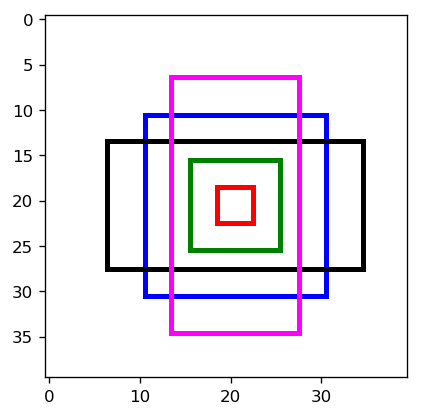

In [6]:
colors = ['blue', 'green', 'red', 'black', 'magenta']

plt.imshow(nd.ones((n, n, 3)).asnumpy())
anchors = boxes[20, 20, :, :]
for i in range(anchors.shape[0]):
    plt.gca().add_patch(box_to_rect(anchors[i,:]*n, colors[i]))
plt.show()

### 预测物体类别

对每一个锚框我们需要预测它是不是包含了我们感兴趣的物体，还是只是背景。这里我们使用一个$3\times 3$的卷积层来做预测，加上`pad=1`使用它的输出和输入一样。同时输出的通道数是`num_anchors*(num_classes+1)`，每个通道对应一个锚框对某个类的置信度。假设输出是`Y`，那么对应输入中第$n$个样本的第$(i,j)$像素的置信值是在`Y[n,:,i,j]`里。具体来说，对于以`(i,j)`为中心的第`a`个锚框，

- 通道 `a*(num_class+1)` 是其只包含背景的分数
- 通道 `a*(num_class+1)+1+b` 是其包含第`b`个物体的分数

我们定义个一个这样的类别分类器函数：

In [7]:
from mxnet.gluon import nn
def class_predictor(num_anchors, num_classes):
    """return a layer to predict classes"""
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

cls_pred = class_predictor(5, 10)
cls_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
y = cls_pred(x)
y.shape

(2, 55, 20, 20)

### 预测边界框

因为真实的边界框可以是任意形状，我们需要预测如何从一个锚框变换成真正的边界框。这个变换可以由一个长为4的向量来描述。同上一样，我们用一个有`num_anchors * 4`通道的卷积。假设输出是Y，那么对应输入中第 $n$ 个样本的第 $(i,j)$
像素为中心的锚框的转换在`Y[n,:,i,j]`里。具体来说，对于第`a`个锚框，它的变换在`a*4`到`a*4+3`通道里。

In [8]:
def box_predictor(num_anchors):
    """return a layer to predict delta locations"""
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

box_pred = box_predictor(10)
box_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
y = box_pred(x)
y.shape

(2, 40, 20, 20)

### 减半模块

我们定义一个卷积块，它将输入特征的长宽减半，以此来获取多尺度的预测。它由两个`Conv-BatchNorm-Relu`组成，我们使用填充为1的$3\times 3$卷积使得输入和输入有同样的长宽，然后再通过跨度为2的最大池化层将长宽减半。

In [9]:
def down_sample(num_filters):
    """stack two Conv-BatchNorm-Relu blocks and then a pooling layer
    to halve the feature size"""
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

blk = down_sample(10)
blk.initialize()
x = nd.zeros((2, 3, 20, 20))
y = blk(x)
y.shape

(2, 10, 10, 10)

### 合并来自不同层的预测输出

前面我们提到过SSD的一个重要性质是它会在多个层同时做预测。每个层由于长宽和锚框选择不一样，导致输出的数据形状会不一样。这里我们用物体类别预测作为样例，边框预测是类似的。

我们首先创建一个特定大小的输入，然后对它输出类别预测。然后对输入减半，再输出类别预测。

In [10]:
x = nd.zeros((2, 8, 20, 20))
print('x:', x.shape)

cls_pred1 = class_predictor(5, 10)
cls_pred1.initialize()
y1 = cls_pred1(x)
print('Class prediction 1:', y1.shape)

ds = down_sample(16)
ds.initialize()
x = ds(x)
print('x:', x.shape)

cls_pred2 = class_predictor(3, 10)
cls_pred2.initialize()
y2 = cls_pred2(x)
print('Class prediction 2:', y2.shape)

x: (2, 8, 20, 20)
Class prediction 1: (2, 55, 20, 20)
x: (2, 16, 10, 10)
Class prediction 2: (2, 33, 10, 10)


可以看到`y1`和`y2`形状不同。为了之后处理简单，我们将不同层的输入合并成一个输出。首先我们将通道移到最后的维度，然后将其展成2D数组。因为第一个维度是样本个数，所以不同输出之间是不变，我们可以将所有输出在第二个维度上拼接起来。

In [11]:
def flatten_prediction(pred):
    return pred.transpose(axes=(0,2,3,1)).flatten()

def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

flat_y1 = flatten_prediction(y1)
print('Flatten class prediction 1', flat_y1.shape)
flat_y2 = flatten_prediction(y2)
print('Flatten class prediction 2', flat_y2.shape)
y = concat_predictions([flat_y1, flat_y2])
print('Concat class predictions', y.shape)

Flatten class prediction 1 (2, 22000)
Flatten class prediction 2 (2, 3300)
Concat class predictions (2, 25300)


### 主体网络

主体网络用来从原始像素抽取特征。通常前面介绍的用来图片分类的卷积神经网络，例如ResNet，都可以用来作为主体网络。这里为了示范，我们简单叠加几个减半模块作为主体网络。

In [12]:
def body():
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out

bnet = body()
bnet.initialize()
x = nd.random.uniform(shape=(2,3,256,256))
y = bnet(x)
y.shape

(2, 64, 32, 32)

### 创建一个玩具SSD模型

现在我们可以创建一个玩具SSD模型了。我们称之为玩具是因为这个网络不管是层数还是锚框个数都比较小，仅仅适合之后我们之后使用的一个小数据集。但这个模型不会影响我们介绍SSD。

这个网络包含四块。主体网络，三个减半模块，以及五个物体类别和边框预测模块。其中预测分别应用在在主体网络输出，减半模块输出，和最后的全局池化层上。

In [13]:
def toy_ssd_model(num_anchors, num_classes):
    downsamplers = nn.Sequential()
    for _ in range(3):
        downsamplers.add(down_sample(128))
        
    class_predictors = nn.Sequential()
    box_predictors = nn.Sequential()    
    for _ in range(5):
        class_predictors.add(class_predictor(num_anchors, num_classes))
        box_predictors.add(box_predictor(num_anchors))

    model = nn.Sequential()
    model.add(body(), downsamplers, class_predictors, box_predictors)
    return model

### 计算预测

给定模型和每层预测输出使用的锚框大小和形状，我们可以定义前向函数。

In [14]:
def toy_ssd_forward(x, model, sizes, ratios, verbose=False):    
    body, downsamplers, class_predictors, box_predictors = model
    anchors, class_preds, box_preds = [], [], []
    # feature extraction    
    x = body(x)
    for i in range(5):
        # predict
        anchors.append(MultiBoxPrior(
            x, sizes=sizes[i], ratios=ratios[i]))
        class_preds.append(
            flatten_prediction(class_predictors[i](x)))
        box_preds.append(
            flatten_prediction(box_predictors[i](x)))
        if verbose:
            print('Predict scale', i, x.shape, 'with', 
                  anchors[-1].shape[1], 'anchors')
        # down sample
        if i < 3:
            x = downsamplers[i](x)
        elif i == 3:
            x = nd.Pooling(
                x, global_pool=True, pool_type='max', 
                kernel=(x.shape[2], x.shape[3]))
    # concat date
    return (concat_predictions(anchors),
            concat_predictions(class_preds),
            concat_predictions(box_preds))


### 完整的模型

In [15]:
from mxnet import gluon
class ToySSD(gluon.Block):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor box sizes and ratios for 5 feature scales
        self.sizes = [[.2,.272], [.37,.447], [.54,.619], 
                      [.71,.79], [.88,.961]]
        self.ratios = [[1,2,.5]]*5
        self.num_classes = num_classes
        self.verbose = verbose
        num_anchors = len(self.sizes[0]) + len(self.ratios[0]) - 1
        # use name_scope to guard the names
        with self.name_scope():
            self.model = toy_ssd_model(num_anchors, num_classes)

    def forward(self, x):
        anchors, class_preds, box_preds = toy_ssd_forward(
            x, self.model, self.sizes, self.ratios, 
            verbose=self.verbose)
        # it is better to have class predictions reshaped for softmax computation       
        class_preds = class_preds.reshape(shape=(0, -1, self.num_classes+1))
        return anchors, class_preds, box_preds

我们看看一下输入图片的形状是如何改变的，已经输出的形状。

In [16]:
net = ToySSD(num_classes=2, verbose=True)
net.initialize()
x = batch.data[0][0:1]
print('Input:', x.shape)
anchors, class_preds, box_preds = net(x)
print('Output achors:', anchors.shape)
print('Output class predictions:', class_preds.shape)
print('Output box predictions:', box_preds.shape)

Input: (1, 3, 256, 256)
Predict scale 0 (1, 64, 32, 32) with 4096 anchors
Predict scale 1 (1, 128, 16, 16) with 1024 anchors
Predict scale 2 (1, 128, 8, 8) with 256 anchors
Predict scale 3 (1, 128, 4, 4) with 64 anchors
Predict scale 4 (1, 128, 1, 1) with 4 anchors
Output achors: (1, 5444, 4)
Output class predictions: (1, 5444, 3)
Output box predictions: (1, 21776)


## 训练

之前的教程我们主要是关注分类。对于分类的预测结果和真实的标号，我们通过交叉熵来计算他们的差异。但物体检测里我们需要预测边框。这里我们先引入一个概率来描述两个边框的距离。

### IoU：交集除并集

我们知道判断两个集合的相似度最常用的衡量叫做Jaccard距离，给定集合 $A$ 和 $B$，它的定义是 

$$J(A,B) = \frac{|A\cap B|}{| A \cup B|}$$

边框可以看成是像素的集合，我们可以类似的定义它。这个标准通常被称之为 Intersection over Union (IoU)。

![](../img/iou.svg)

大的值表示两个边框很相似，而小的值则表示不相似。

### 损失函数

虽然每张图片里面通常只有几个标注的边框，但SSD会生成大量的锚框。可以想象很多锚框都不会框住感兴趣的物体，就是说跟任何对应感兴趣物体的表框的IoU都小于某个阈值。这样就会产生大量的负类锚框，或者说对应标号为0的锚框。对于这类锚框有两点要考虑的：

1. 边框预测的损失函数不应该包括负类锚框，因为它们并没有对应的真实边框
1. 因为负类锚框数目可能远多于其他，我们可以只保留其中的一些。而且是保留那些目前预测最不确信它是负类的，就是对类0预测值排序，选取数值最小的哪一些困难的负类锚框。

我们可以使用`MultiBoxTarget`来完成上面这两个操作。

In [17]:
from mxnet.contrib.ndarray import MultiBoxTarget
def training_targets(anchors, class_preds, labels):
    class_preds = class_preds.transpose(axes=(0,2,1))
    return MultiBoxTarget(anchors, labels, class_preds)

out = training_targets(anchors, class_preds, batch.label[0][0:1]) 
out

[
 [[ 0.  0.  0. ...,  0.  0.  0.]]
 <NDArray 1x21776 @cpu(0)>, 
 [[ 0.  0.  0. ...,  0.  0.  0.]]
 <NDArray 1x21776 @cpu(0)>, 
 [[ 0.  0.  0. ...,  0.  0.  0.]]
 <NDArray 1x5444 @cpu(0)>]

它返回三个`NDArray`，分别是

1. 预测的边框跟真实边框的偏移，大小是`batch_size x (num_anchors*4)`
1. 用来遮掩不需要的负类锚框的掩码，大小跟上面一致
1. 锚框的真实的标号，大小是`batch_size x num_anchors`

我们可以计算这次只选中了多少个锚框进入损失函数：

In [18]:
out[1].sum()/4


[ 1.]
<NDArray 1 @cpu(0)>

然后我们可以定义需要的损失函数了。

对于分类问题，最常用的损失函数是之前一直使用的交叉熵。这里我们定义一个类似于交叉熵的损失，不同于交叉熵的定义 $\log(p_j)$，这里 $j$ 是真实的类别，且 $p_j$ 是对于的预测概率。我们使用一个被称之为关注损失的函数，给定正的$\gamma$和$\alpha$，它的定义是

$$ - \alpha (1-p_j)^{\gamma} \log(p_j) $$

下图我们演示不同$\gamma$导致的变化。可以看到，增加$\gamma$可以使得对正类预测值比较大时损失变小。

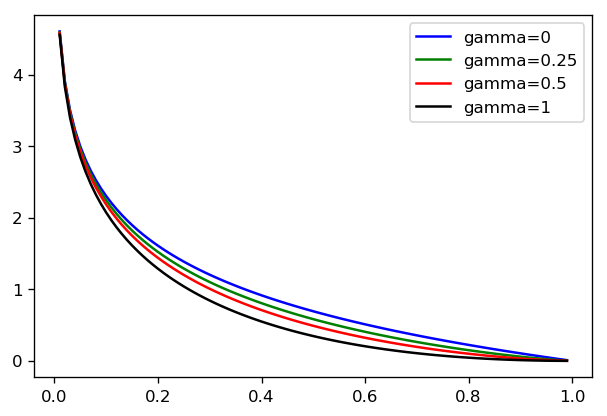

In [19]:
import numpy as np

def focal_loss(gamma, x):
    return - (1-x)**gamma*np.log(x)

x = np.arange(0.01, 1, .01)
gammas = [0,.25,.5,1]
for i,g in enumerate(gammas):
    plt.plot(x, focal_loss(g,x), colors[i])

plt.legend(['gamma='+str(g) for g in gammas])
plt.show()

这个自定义的损失函数可以简单通过继承`gluon.loss.Loss`来实现。

In [20]:
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma

    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pj = output.pick(label, axis=self._axis, keepdims=True)
        loss = - self._alpha * ((1 - pj) ** self._gamma) * pj.log()
        return loss.mean(axis=self._batch_axis, exclude=True)

cls_loss = FocalLoss()
cls_loss

FocalLoss(batch_axis=0, w=None)

对于边框的预测是一个回归问题。通常可以选择平方损失函数（L2损失）$f(x)=x^2$。但这个损失对于比较大的误差的惩罚很高。我们可以采用稍微缓和一点绝对损失函数（L1损失）$f(x)=|x|$，它是随着误差线性增长，而不是平方增长。但这个函数在0点处导数不唯一，因此可能会影响收敛。一个通常的解决办法是在0点附近使用平方函数使得它更加平滑。它被称之为平滑L1损失函数。它通过一个参数$\sigma$来控制平滑的区域：

$$
f(x) =
    \begin{cases}
    (\sigma x)^2/2,& \text{if }x < 1/\sigma^2\\
    |x|-0.5/\sigma^2,& \text{otherwise}
    \end{cases}
$$

我们图示不同的$\sigma$的平滑L1损失和L2损失的区别。

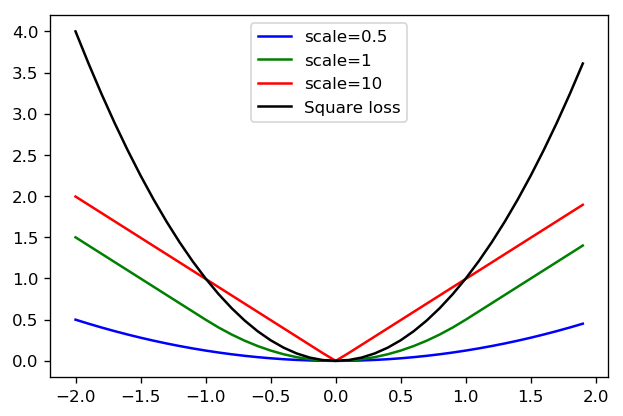

In [21]:
scales = [.5, 1, 10]
x = nd.arange(-2, 2, 0.1)

for i,s in enumerate(scales):
    y = nd.smooth_l1(x, scalar=s)
    plt.plot(x.asnumpy(), y.asnumpy(), color=colors[i])
plt.plot(x.asnumpy(), (x**2).asnumpy(), color=colors[len(scales)])
plt.legend(['scale='+str(s) for s in scales]+['Square loss'])
plt.show()

我们同样通过继承`Loss`来定义这个损失。同时它接受一个额外参数`mask`，这是用来屏蔽掉不需要被惩罚的负例样本。

In [22]:
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)

    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar=1.0)
        return loss.mean(self._batch_axis, exclude=True)

box_loss = SmoothL1Loss()
box_loss

SmoothL1Loss(batch_axis=0, w=None)

### 评估测量

对于分类好坏我们可以沿用之前的分类精度。评估边框预测的好坏的一个常用是是平均绝对误差。记得在[线性回归](../chapter_supervised-learning/linear-regression-scratch.md)我们使用了平均平方误差。但跟上面对损失函数的讨论一样，平方误差对于大的误差给予过大的值，从而数值上过于敏感。平均绝对误差就是将二次项替换成绝对值，具体来说就是预测的边框和真实边框在4个维度上的差值的绝对值。

In [23]:
from mxnet import metric

cls_metric = metric.Accuracy()
box_metric = metric.MAE() 

### 初始化模型和训练器

In [24]:
from mxnet import init
from mxnet import gpu

ctx = gpu(0)
# the CUDA implementation requres each image has at least 3 lables. 
# Padd two -1 labels for each instance 
train_data.reshape(label_shape=(3, 5))
train_data = test_data.sync_label_shape(train_data)

net = ToySSD(num_class)
net.initialize(init.Xavier(magnitude=2), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 
                        'sgd', {'learning_rate': 0.1, 'wd': 5e-4})

### 训练模型

训练函数跟前面的不一样在于网络会有多个输出，而且有两个损失函数。

In [25]:
import time
from mxnet import autograd
for epoch in range(30):
    # reset data iterators and metrics 
    train_data.reset()
    cls_metric.reset()
    box_metric.reset()
    tic = time.time()
    for i, batch in enumerate(train_data):
        x = batch.data[0].as_in_context(ctx)
        y = batch.label[0].as_in_context(ctx)
        with autograd.record():
            anchors, class_preds, box_preds = net(x)
            box_target, box_mask, cls_target = training_targets(
                anchors, class_preds, y)
            # losses
            loss1 = cls_loss(class_preds, cls_target)
            loss2 = box_loss(box_preds, box_target, box_mask)
            loss = loss1 + loss2
        loss.backward()
        trainer.step(batch_size)
        # update metrics
        cls_metric.update([cls_target], [class_preds.transpose((0,2,1))])
        box_metric.update([box_target], [box_preds * box_mask])

    print('Epoch %2d, train %s %.2f, %s %.5f, time %.1f sec' % (
        epoch, *cls_metric.get(), *box_metric.get(), time.time()-tic
    ))

Epoch  0, train accuracy 0.95, mae 0.00419, time 12.6 sec


Epoch  1, train accuracy 0.99, mae 0.00361, time 10.5 sec


Epoch  2, train accuracy 0.99, mae 0.00346, time 10.4 sec


Epoch  3, train accuracy 0.99, mae 0.00334, time 10.5 sec


Epoch  4, train accuracy 0.99, mae 0.00330, time 10.4 sec


Epoch  5, train accuracy 1.00, mae 0.00306, time 10.5 sec


Epoch  6, train accuracy 1.00, mae 0.00307, time 10.5 sec


Epoch  7, train accuracy 1.00, mae 0.00312, time 10.5 sec


Epoch  8, train accuracy 1.00, mae 0.00304, time 10.5 sec


Epoch  9, train accuracy 1.00, mae 0.00294, time 10.5 sec


Epoch 10, train accuracy 1.00, mae 0.00297, time 10.4 sec


Epoch 11, train accuracy 1.00, mae 0.00289, time 10.5 sec


Epoch 12, train accuracy 1.00, mae 0.00293, time 10.5 sec


Epoch 13, train accuracy 1.00, mae 0.00292, time 10.4 sec


Epoch 14, train accuracy 1.00, mae 0.00292, time 10.4 sec


Epoch 15, train accuracy 1.00, mae 0.00276, time 10.5 sec


Epoch 16, train accuracy 1.00, mae 0.00285, time 10.4 sec


Epoch 17, train accuracy 1.00, mae 0.00287, time 10.5 sec


Epoch 18, train accuracy 1.00, mae 0.00277, time 10.5 sec


Epoch 19, train accuracy 1.00, mae 0.00274, time 10.4 sec


Epoch 20, train accuracy 1.00, mae 0.00284, time 10.4 sec


Epoch 21, train accuracy 1.00, mae 0.00267, time 10.5 sec


Epoch 22, train accuracy 1.00, mae 0.00263, time 10.5 sec


Epoch 23, train accuracy 1.00, mae 0.00276, time 10.4 sec


Epoch 24, train accuracy 1.00, mae 0.00265, time 10.5 sec


Epoch 25, train accuracy 1.00, mae 0.00276, time 10.4 sec


Epoch 26, train accuracy 1.00, mae 0.00270, time 10.4 sec


Epoch 27, train accuracy 1.00, mae 0.00255, time 10.5 sec


Epoch 28, train accuracy 1.00, mae 0.00249, time 10.5 sec


Epoch 29, train accuracy 1.00, mae 0.00255, time 10.5 sec


## 预测

在预测阶段，我们希望能把图片里面所有感兴趣的物体找出来。

我们先定一个数据读取和预处理函数。

In [26]:
def process_image(fname):
    with open(fname, 'rb') as f:
        im = image.imdecode(f.read())
    # resize to data_shape
    data = image.imresize(im, data_shape, data_shape)
    # minus rgb mean
    data = data.astype('float32') - rgb_mean
    # convert to batch x channel x height xwidth
    return data.transpose((2,0,1)).expand_dims(axis=0), im


然后我们跟训练那样预测表框和其对应的物体。但注意到因为我们对每个像素都会生成数个锚框，这样我们可能会预测出大量相似的表框，从而导致结果非常嘈杂。一个办法是对于IoU比较高的两个表框，我们只保留预测执行度比较高的那个。这个算法（称之为non maximum suppression）在`MultiBoxDetection`里实现了。下面我们实现预测函数：

In [27]:
from mxnet.contrib.ndarray import MultiBoxDetection

def predict(x):
    anchors, cls_preds, box_preds = net(x.as_in_context(ctx))
    cls_probs = nd.SoftmaxActivation(
        cls_preds.transpose((0,2,1)), mode='channel')

    return MultiBoxDetection(cls_probs, box_preds, anchors,
                             force_suppress=True, clip=False)

预测函数会输出所有边框，每个边框由`[class_id, confidence, xmin, ymin, xmax, ymax]`表示。其中`class_id=-1`表示要么这个边框被预测只含有背景，或者被去重掉了。

In [28]:
x, im = process_image('../img/pikachu.jpg')
out = predict(x)
out.shape

(1, 5444, 6)

最后我们将预测出置信度超过某个阈值的边框画出来：

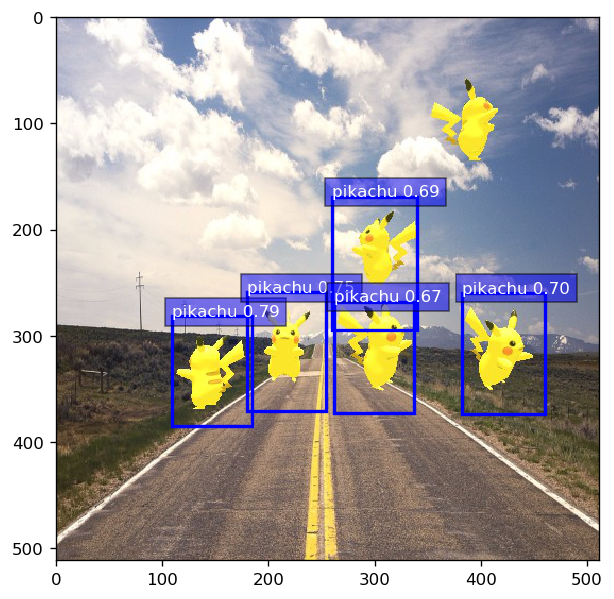

In [29]:
mpl.rcParams['figure.figsize'] = (6,6)

def display(im, out, threshold=0.5):    
    plt.imshow(im.asnumpy())
    for row in out:
        row = row.asnumpy()
        class_id, score = int(row[0]), row[1]
        if class_id < 0 or score < threshold:
            continue
        color = colors[class_id%len(colors)]
        box = row[2:6] * np.array([im.shape[0],im.shape[1]]*2)
        rect = box_to_rect(nd.array(box), color, 2)
        plt.gca().add_patch(rect)
                        
        text = class_names[class_id]
        plt.gca().text(box[0], box[1], 
                       '{:s} {:.2f}'.format(text, score),
                       bbox=dict(facecolor=color, alpha=0.5),
                       fontsize=10, color='white')
    plt.show()

display(im, out[0], threshold=0.5)

## 结论

物体检测比分类要困难很多。因为我们不仅要预测物体类别，还要找到它们的位置。这一章我们展示我们还是可以在合理篇幅里实现SSD算法。

## 练习

我们有很多细节并没有展开讨论。例如

1. 锚框的大小和长宽比是如何选取的
1. `MultiBoxTarget`里我们没有采样负例
1. 分类和回归损失我们直接加起来了，并没有给予权重
1. 在展示的时候如何选取阈值`threshold`


**吐槽和讨论欢迎点**[这里](https://discuss.gluon.ai/t/topic/2511)